In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Imports

import os
import csv
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from pathlib import Path

plt.ion()   # interactive mode

Definindo o conjunto de dados que será utilizados, caminho dos coeficientes e o arquivo csv que armazenará as métricas.

In [ ]:
main_dir = os.path.join("gdrive", "MyDrive", "IA901-2023S1", "data")

data_dir = os.path.join(main_dir, "filtered")
model_path = os.path.join(main_dir, "weights", "coefficients_no_process.pt")
results_path = os.path.join(main_dir, "weights", "results_test_no_process.csv")

Carregar dados

In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.ToTensor()
    ]),
    'VAL': transforms.Compose([
        transforms.ToTensor()
    ]),
    'TEST': transforms.Compose([
        transforms.ToTensor()
    ])
}

# Carrega o conjunto de dados de imagens
image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['TRAIN', 'VAL', 'TEST']}

# Cria um DataLoader para carregar as imagens
batch_size = 1
loader = torch.utils.data.DataLoader(image_datasets['TRAIN'], batch_size=batch_size, shuffle=False)

# Calcula a média e o desvio padrão das imagens
mean = 0.
std = 0.
n_images = 0

for images, _, _ in loader:
    batch_samples = images.size(0)
    images = torch.stack(tuple(images), dim=0)
    n_images += batch_samples
    mean += images.mean([0, 2, 3]) * batch_samples
    std += images.std([0, 2, 3]) * batch_samples
mean /= n_images
std /= n_images

print('mean:', mean)
print('std:', std)

mean: tensor([0.7165, 0.6898, 0.6662])
std: tensor([0.2212, 0.2227, 0.2265])


In [ ]:
# Função auxiliar para definir a semente de cada trabalhador
def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    torch.manual_seed(42 + worker_id)

# Definir a semente
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data augmentation and normalization for training

data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'VAL': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'TEST': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['TRAIN', 'VAL', 'TEST']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['TRAIN', 'VAL', 'TEST']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'VAL', 'TEST']}
class_names = image_datasets['TRAIN'].classes

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Função para visualizar as imagens.

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = np.asarray(inp).transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
num_classes = 5

# Carregar o modelo MobileNetV2 com a última camada modificada
model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier[-1] = nn.Linear(model.last_channel, num_classes)

# Mover o modelo para o dispositivo
model = model.to(device)

# Carregar os pesos do modelo
model.load_state_dict(torch.load(model_path, map_location=device))

# Modo de avaliação
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Loop de test
pred_test = []
true_labels_test = []
images_test = []
img_name = []

with torch.no_grad():
    for inputs, labels, path in dataloaders['TEST']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        img_name.extend(path)

        images_test.extend(inputs.cpu().numpy())

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        pred_test.extend(preds.cpu().numpy())
        true_labels_test.extend(labels.cpu().numpy())


Lendo apenas os nomes dos arquivos, sem o sufixo.

In [ ]:
img_name_list = [Path(curr_img).stem for curr_img in img_name]
print(img_name_list)

['00000050', '00000067', '00000081', '00000052', '00000030', '00000022', '00000117', '00000077', '00000106', '00000101', '00000022', '00000092', '00000036', '00000024', '00000084', '00000057', '00000068', '00000061', '00000020', '00000058', '00000056', '00000103', '00000073', '00000005', '00000010', '00000096', '00000056', '00000017', '00000112', '00000024', '00000004', '00000025', '00000100', '00000011', '00000093', '00000087', '00000059', '00000040', '00000045', '00000016', '00000127', '00000031', '00000015', '00000044', '00000009', '00000014', '00000019', '00000040', '00000043', '00000093', '00000086', '00000073', '00000105', '00000081', '00000101', '00000058', '00000022', '00000049', '00000123', '00000056', '00000067', '00000070', '00000053', '00000043', '00000085', '00000027', '00000047', '00000002', '00000060', '00000058', '00000098', '00000014', '00000059', '00000032', '00000037', '00000003', '00000094', '00000013', '00000082', '00000016', '00000021', '00000021', '00000054', '00

Visualizando as imagens que foram classificadas incorretamente.

Índices das imagens mal classificadas: [47, 96, 97, 107, 129, 141, 143, 153, 189, 193, 218, 220, 246, 248, 285, 290, 341, 384, 408]


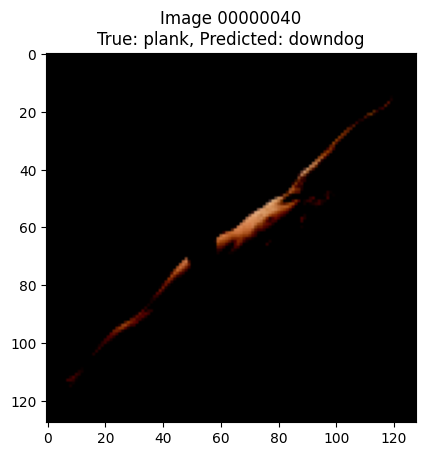

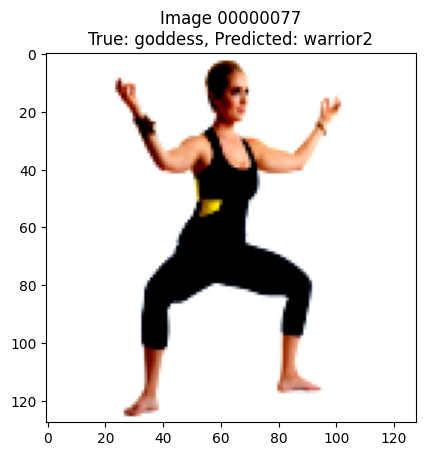

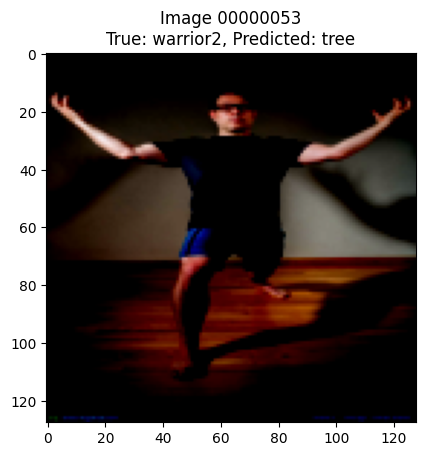

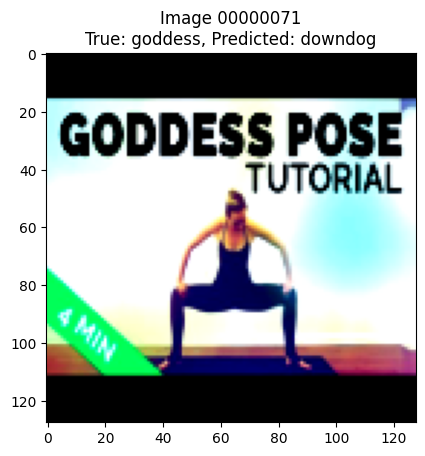

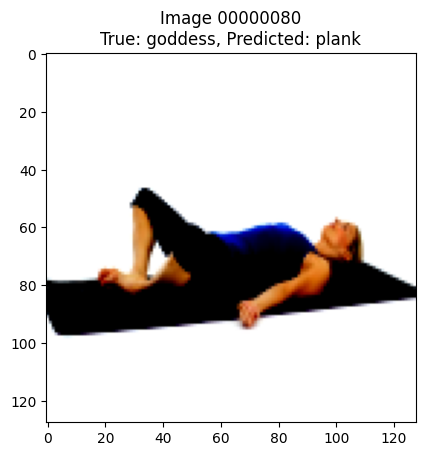

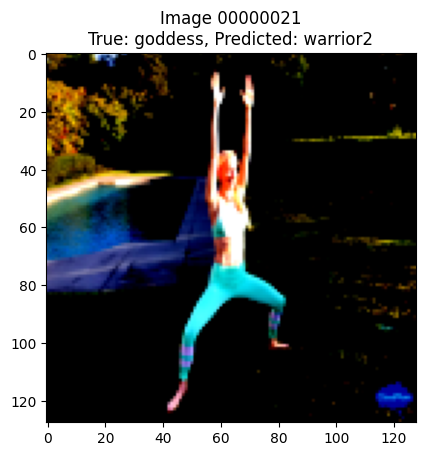

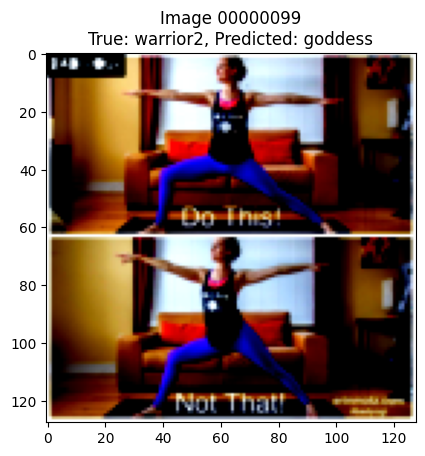

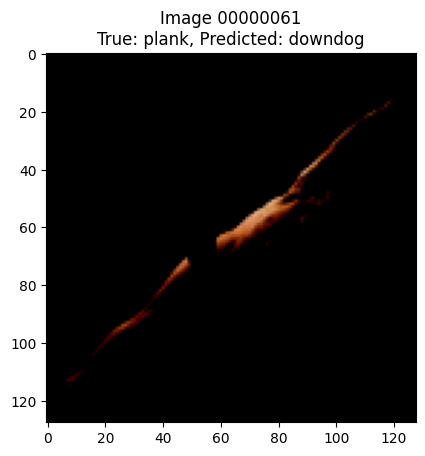

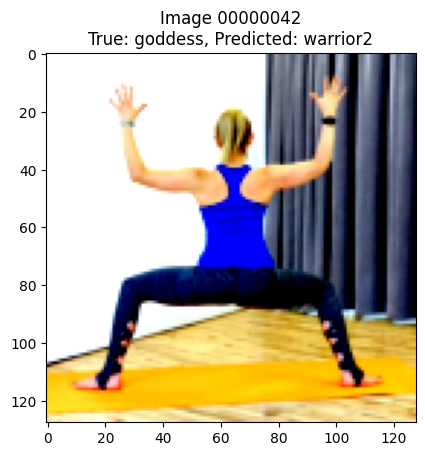

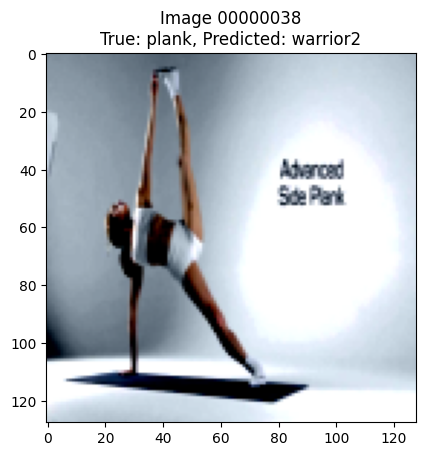

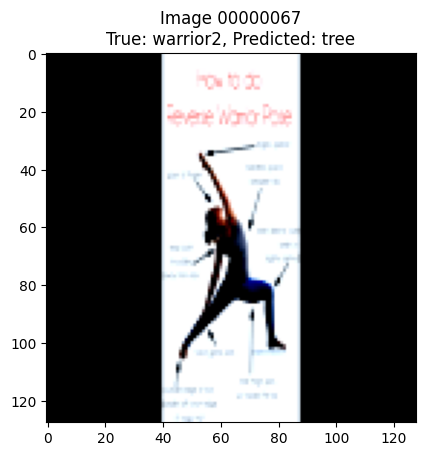

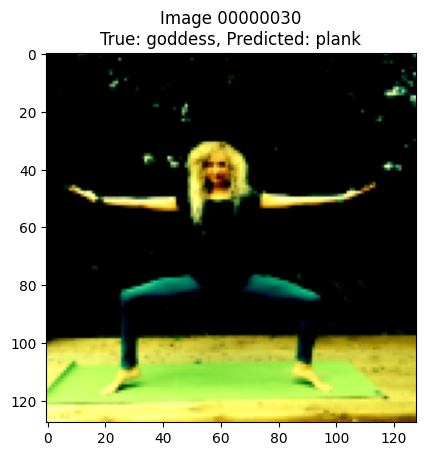

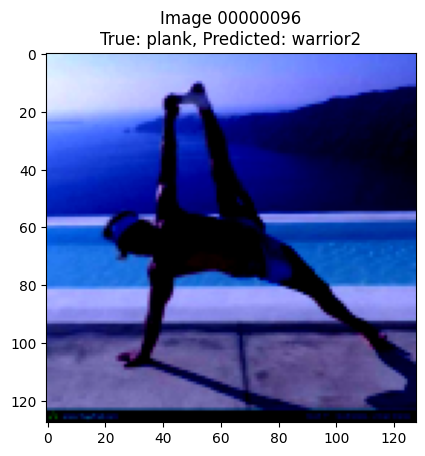

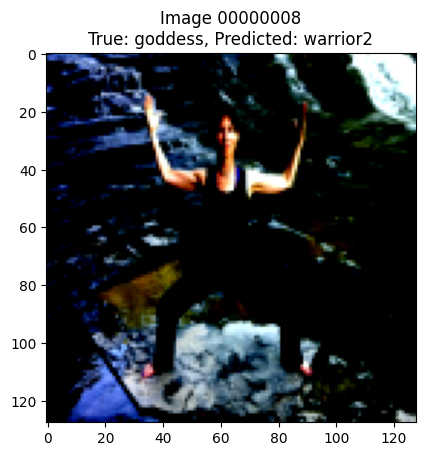

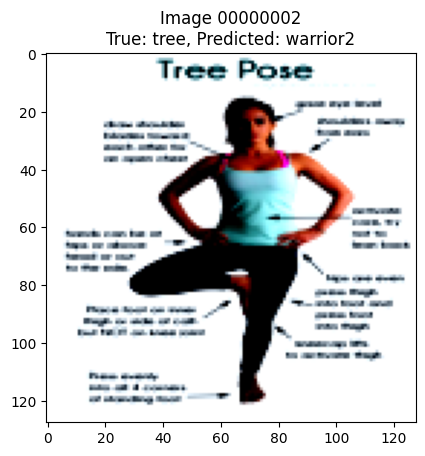

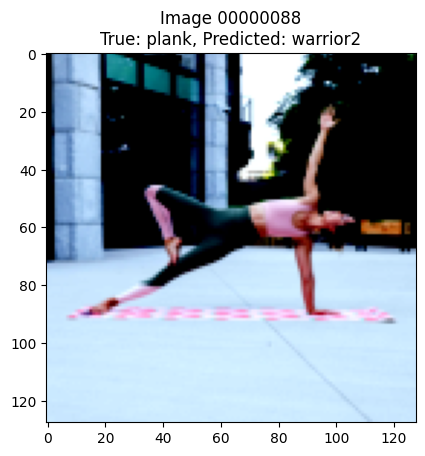

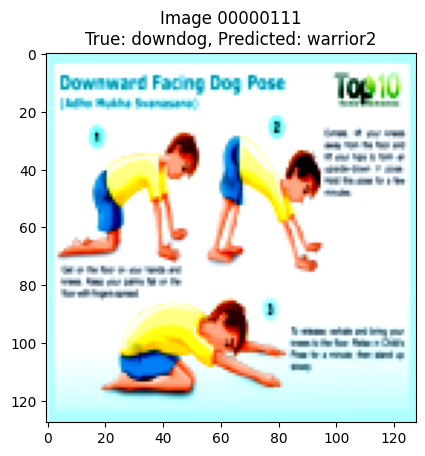

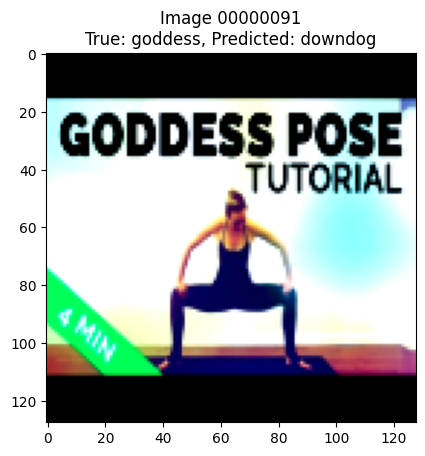

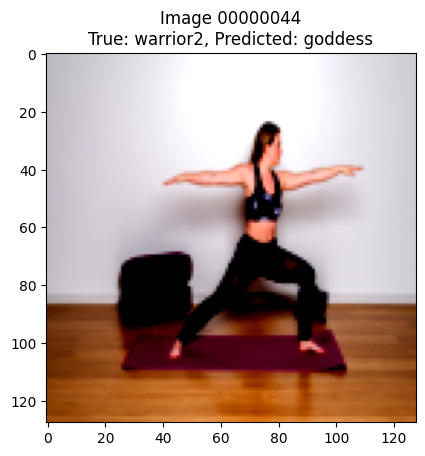

In [ ]:
misclass_id = [idx for idx in range(len(pred_test)) if pred_test[idx] != true_labels_test[idx]]
print("Índices das imagens mal classificadas:", misclass_id)

def show_misclassified_images(dataset, misclassified_idx, class_names, pred_test, true_labels_test):
    for idx in misclassified_idx:
        title = f"Image {img_name_list[idx]}\nTrue: {class_names[true_labels_test[idx]]}, Predicted: {class_names[pred_test[idx]]}"
        imshow(images_test[idx], title=title)

# Exibir imagens mal classificadas
show_misclassified_images(dataloaders['TEST'].dataset, misclass_id, class_names, pred_test, true_labels_test)


## Métricas

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, \
     precision_score, confusion_matrix, ConfusionMatrixDisplay

test_accuracy = accuracy_score(true_labels_test, pred_test)
test_precision = precision_score(true_labels_test, pred_test, average='weighted')
test_bal_accuracy = balanced_accuracy_score(true_labels_test, pred_test)
test_f1 = f1_score(true_labels_test, pred_test, average='weighted')

print('Test Accuracy: {:.4f}'.format(test_accuracy))
print('Test Precision (Weighted): {:.4f}'.format(test_precision))
print('Test Balanced Accuracy: {:.4f}'.format(test_bal_accuracy))
print('Test F1-Score (Weighted): {:.4f}'.format(test_f1))

Test Accuracy: 0.9552
Test Precision (Weighted): 0.9560
Test Balanced Accuracy: 0.9540
Test F1-Score (Weighted): 0.9550


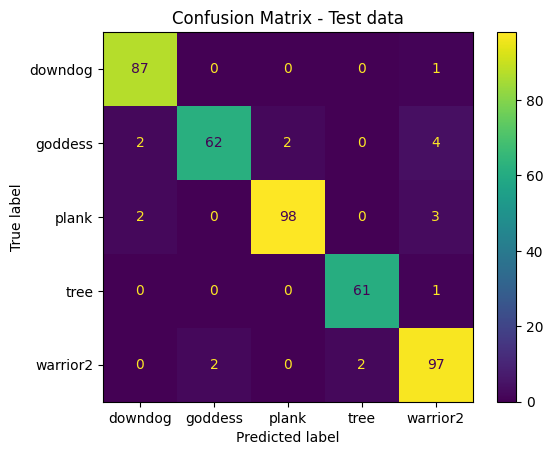

In [ ]:
# Matriz de confusão
confusion_mtx = confusion_matrix(true_labels_test, pred_test)

ConfusionMatrixDisplay(confusion_mtx, display_labels=class_names).plot()
plt.title("Confusion Matrix - Test data")
plt.grid(False)
plt.show()

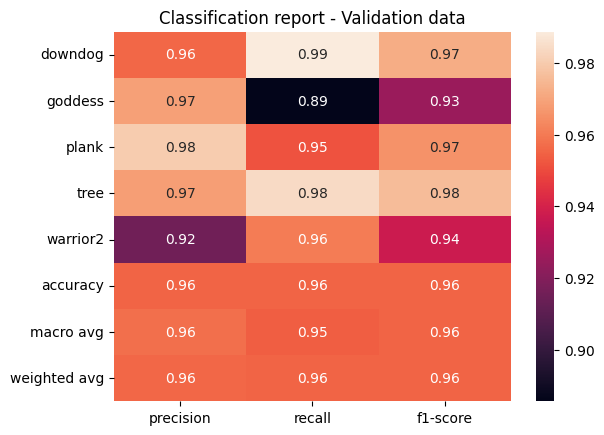

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
classification_report = classification_report(true_labels_test, pred_test,
                                              zero_division=1, output_dict=True,
                                              target_names=class_names)
sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)
plt.title("Classification report - Validation data")

plt.show()

In [ ]:
downdog_metrics = {key : round(classification_report["downdog"][key], 4)
                   for key in classification_report["downdog"]}
goddess_metrics = {key : round(classification_report["goddess"][key], 4)
                   for key in classification_report["goddess"]}
plank_metrics = {key : round(classification_report["plank"][key], 4)
                 for key in classification_report["plank"]}
tree_metrics = {key : round(classification_report["tree"][key], 4)
                for key in classification_report["tree"]}
warrior2_metrics = {key : round(classification_report["warrior2"][key], 4)
                    for key in classification_report["warrior2"]}

In [ ]:
with open(results_path, 'w') as results_file:
    writer = csv.writer(results_file)
    writer.writerow(("Accuracy", "Balanced Accuracy", "Weighted Precision",
                     "Weighted F1-Score", "Downdog Precision", "Downdog Recall",
                     "Downdog F1-Score", "Goddess Precision", "Goddess Recall",
                     "Goddess F1-Score", "Plank Precision", "Plank Recall",
                     "Plank F1-Score", "Tree Precision", "Tree Recall",
                     "Tree F1-Score", "Warrior2 Precision", "Warrior2 Recall",
                     "Warrior2 F1-Score"))
    writer.writerow((test_accuracy, test_bal_accuracy, test_precision, test_f1,
                     downdog_metrics["precision"], downdog_metrics["recall"],
                     downdog_metrics["f1-score"], goddess_metrics["precision"],
                     goddess_metrics["recall"], goddess_metrics["f1-score"],
                     plank_metrics["precision"], plank_metrics["recall"],
                     plank_metrics["f1-score"], tree_metrics["precision"],
                     tree_metrics["recall"], tree_metrics["f1-score"],
                     warrior2_metrics["precision"], warrior2_metrics["recall"],
                     warrior2_metrics["f1-score"]))